In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

In [1]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.tsa.statespace.mlemodel import MLEModel
import statsmodels.api as sm

# 関数定義

In [2]:
def linear_gauss_model(m, G, f, W, V, T, dim=1):
    """線形ガウスモデル."""
    x = np.zeros((T, dim))
    y = np.zeros((T, 1))
     # 正規分布に従う変数を作成
    W = np.random.multivariate_normal(np.zeros(dim), W, T)
    V = np.random.multivariate_normal(np.zeros(1), V, T)
    x[0] = m + W[0]
    y[0] = f @ x[0] + V[0]
    for t in range(1, T):
        # 状態方程式
        x[t] = G @ x[t-1] + W[t]
        # 観測方程式
        y[t] = f @ x[t] + V[t]
    return x, y

In [3]:
def kalman_filter(m, C, y, G, F, W, V):
    """
    m: 時点t-1のフィルタリング分布の期待値
    C: 時点t-1のフィルタリング分布の分散共分散行列
    y: 時点tの観測値
    G: 状態遷移行列
    F: 観測行列
    W: 状態雑音
    V: 観測雑音
    """
    # 1期先予測分布
    a = G @ m
    R = G @ C @ G.T + W
    # 1期先予測尤度
    f = F @ a
    Q = F @ R @ F.T + V
    # カルマン利得
    K = (np.linalg.solve(Q.T, F @ R.T)).T
    # 状態の更新
    m = a + K @ (y - f)
    C = R - K @ F @ R
    return m, C, a, R

In [5]:
def kalman_smoothing(s, S, m, C, G, R, a):
    """
    カルマン平滑化
    Args:
        s: 時点t+1の平滑化分布の期待値
        S: 時点t+1の平滑化分布の分散共分散行列
        m: 時点tのフィルタリング分布の期待値
        C: 時点tのフィルタリング分布の分散共分散行列
        G： 時点t+1の状態遷移行列
        R: 時点t+1の予測分布の分散
    Return: 
        時点tの平滑化分布の期待値
        時点tの平滑化分布の分散
    """
    # 平滑化利得
    A = np.linalg.solve(R, C @ G.T)
    # 状態の更新
    s = m + A @ (s - a)
    S = C + A @ (S - R) @ A.T
    return s, S

In [6]:
def ffbs(m, C, G, x, a, R):
    """
    パラメータを既知とした場合のFFBSアルゴリズム
    Args:
        m: 時点t+1のフィルタリング分布の期待値
        C: 時点t+1のフィルタリング分布の分散
        x: 時点t+1でサンプリングされた状態
        a: 時点t+1の予測分布の平均
        R: 時点t+1の予測分布の分散
    """
    # 平滑化利得
    A = np.linalg.solve(R, C @ G.T)
    h = m + A @ (x - a)
    H = C + A @ (-R) @ A.T
    x = np.random.multivariate_normal(h, H)
    return x

In [7]:
def mape(pred, true):
    return np.mean(np.abs((pred - true) / true)) * 100

# 分析

## ローカルレベルモデル

### データ生成

In [8]:
# 設定
m0 = np.array([[10]]) # 状態変数の初期値
C0 = np.array([[9]]) # フィルタリング分布の共分散行列
G = np.array([[1]]) # 状態遷移行列
f = np.array([[1]]) # 観測行列
W = np.array([[1]]) # 状態雑音
V = np.array([[2]]) # 観測雑音
T = 200

In [9]:
x,y = linear_gauss_model(m=m0, G=G, f=f, W=W, V=V, T=T, dim=1)

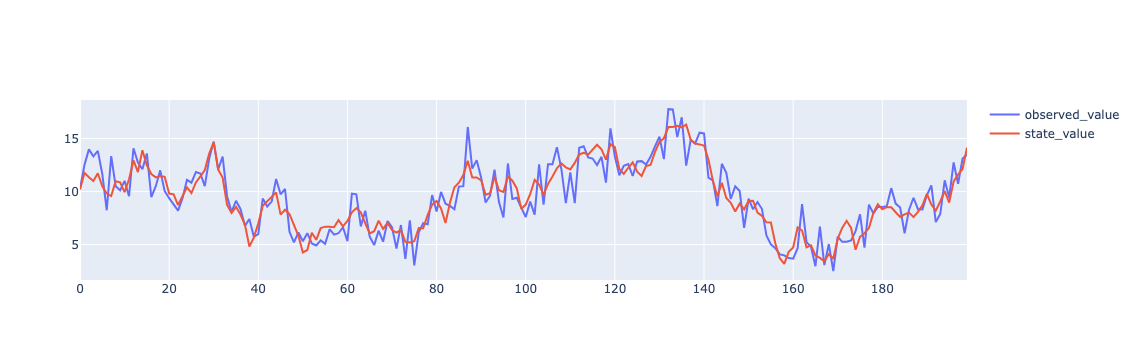

In [10]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x.reshape(-1), name="state_value"),
    ]
)
fig.show()

### カルマンフィルタ

In [11]:
m = np.zeros((T, 1))
C = np.zeros((T, 1, 1))
a = np.zeros((T, 1))
R = np.zeros((T, 1, 1))
m[0] = m0
C[0] = C0
for t in range(1, T):
    m[t], C[t], a[t], R[t] = kalman_filter(m[t-1], C[t-1], y[t], G, f, W, V)

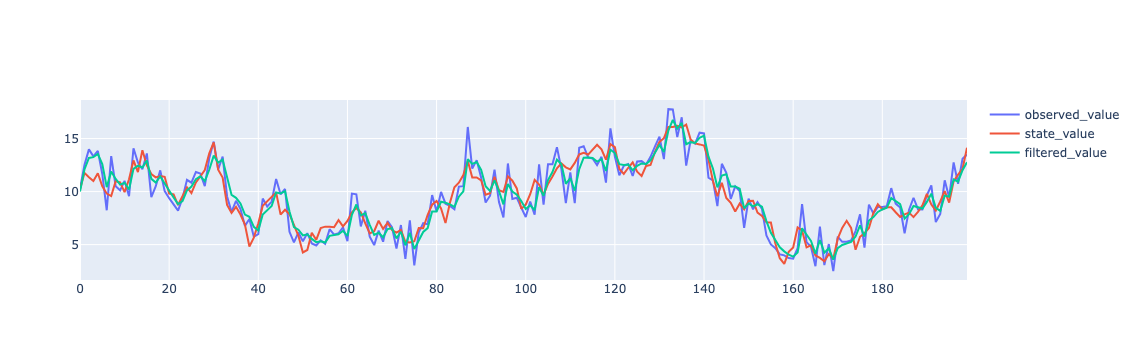

In [12]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x.reshape(-1), name="state_value"),
        go.Scatter(x=np.arange(T), y=m.reshape(-1), name="filtered_value"),
    ]
)
fig.show()

### カルマン平滑化

In [13]:
s = np.zeros((T, 1))
S = np.zeros((T, 1, 1))
s[T-1] = m[T-1]
S[T-1] = C[T-1]
for t in range(T-1, 0, -1):
    s[t-1], S[t-1] = kalman_smoothing(s[t], S[t], m[t-1], C[t-1], G, R[t], a[t])

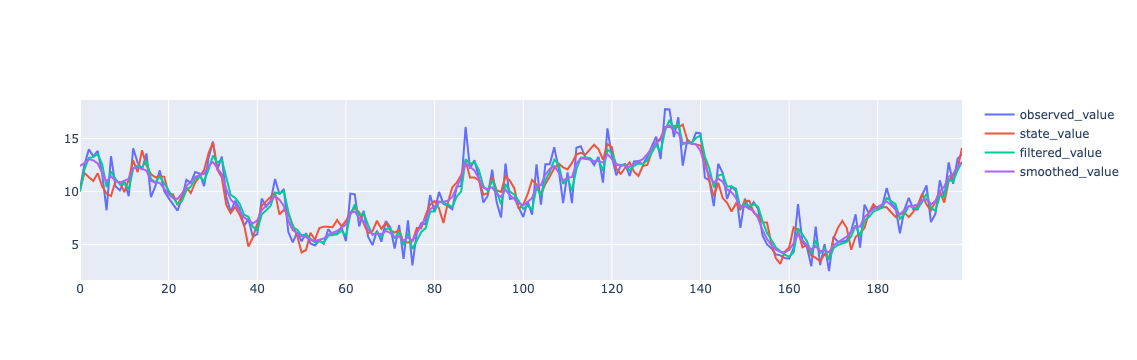

フィルタリング分布：10.04023722581491
平滑化分布：8.25900939281001


In [14]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x.reshape(-1), name="state_value"),
        go.Scatter(x=np.arange(T), y=m.reshape(-1), name="filtered_value"),
        go.Scatter(x=np.arange(T), y=s.reshape(-1), name="smoothed_value"),
    ]
)
fig.show()
print(f"フィルタリング分布：{mape(m, x)}")
print(f"平滑化分布：{mape(s, x)}")

### FFBS

In [20]:
I = 10
x_sample = np.zeros((I, T, 1))
for i in range(I):
    x_sample[i][-1] = np.random.multivariate_normal(m[-1], C[-1])
    for t in range(T-1, 0, -1):
        x_sample[i][t-1] = ffbs(m[t-1], C[t-1], G, x_sample[i][t], a[t], R[t])

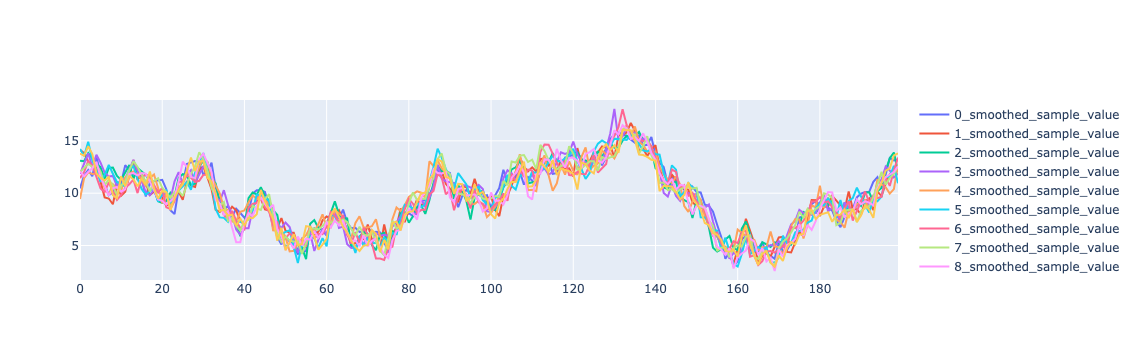

In [22]:
data = []
for i in range(I):
    data.append(
        go.Scatter(x=np.arange(T), y=x_sample[i].reshape(-1), name=f"{i}_smoothed_sample_value")
    )
fig = go.Figure(data)
fig.show()

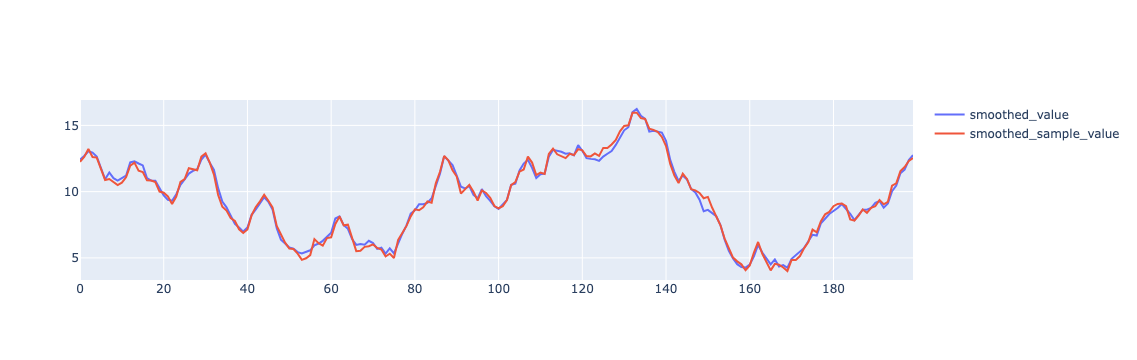

In [26]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=s.reshape(-1), name="smoothed_value"),
        go.Scatter(x=np.arange(T), y=x_sample.mean(axis=0).reshape(-1), name="smoothed_sample_value"),
    ]
)
fig.show()

## ローカルトレンドモデル

### データ生成

In [203]:
# 設定
m0 = np.array([[10, 5]]) # 状態変数の初期値
C0 = np.array([[9, 0], [0, 9]]) # フィルタリング分布の共分散行列
G = np.array([[1, 1], [0, 1]]) # 状態遷移行列
f = np.array([[1, 0]]) # 観測行列
W = np.array([[1, 0], [0, 1]]) # 状態雑音
V = np.array([[2]]) # 観測雑音
T = 200

In [204]:
x,y = linear_gauss_model(m=m0, G=G, f=f, W=W, V=V, T=T, dim=2)

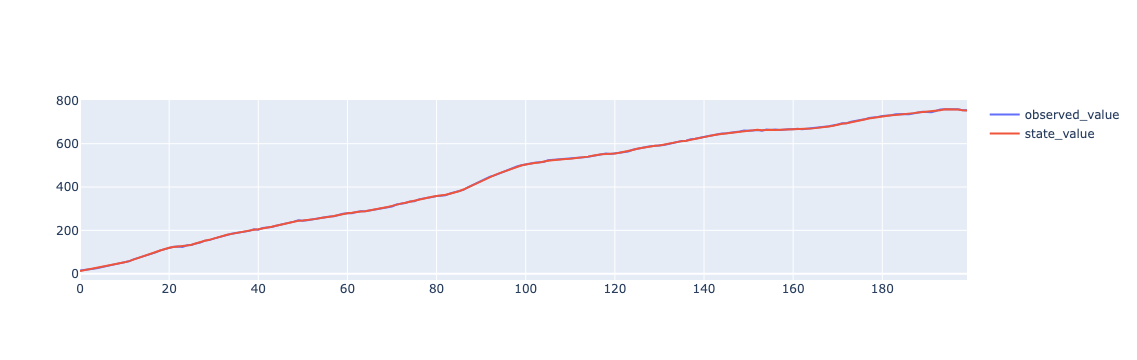

In [205]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x[:, 0].reshape(-1), name="state_value"),
    ]
)
fig.show()

### カルマンフィルタ

In [206]:
m = np.zeros((T, 2))
C = np.zeros((T, 2, 2))
m[0] = m0
C[0] = C0
for t in range(1, T):
    m[t], C[t] = kalman_filter(m[t-1], C[t-1], y[t], G, F, W, V)

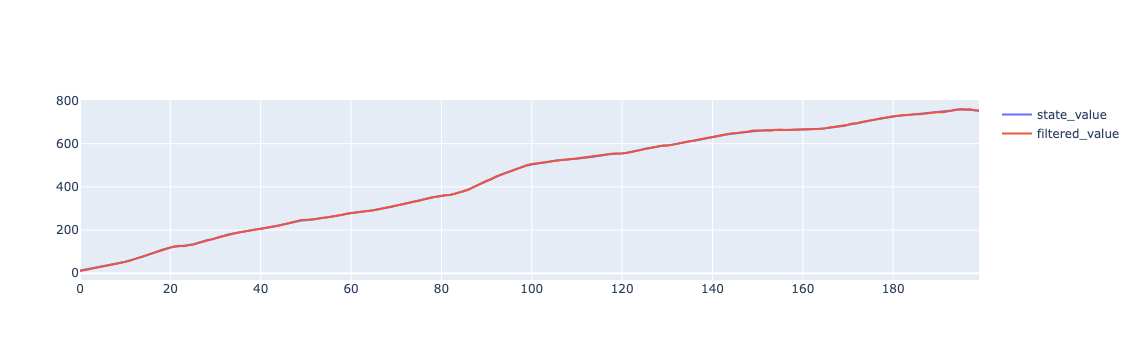

In [207]:
# 可視化
fig = go.Figure(
    data = [
        # go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x[:, 0].reshape(-1), name="state_value"),
        go.Scatter(x=np.arange(T), y=m[:, 0].reshape(-1), name="filtered_value"),
    ]
)
fig.show()

## 周期モデル

### データ生成

In [208]:
# 設定
m0 = np.array([[10, 5, 3]]) # 状態変数の初期値（適当）
C0 = np.array([
    [9, 0, 0], 
    [0, 9, 0],
    [0, 0, 9]
]) # フィルタリング分布の共分散行列
G = np.array([
    [-1, -1, -1], 
    [1, 0, 0],
    [0, 1, 0],
]) # 状態遷移行列
f = np.array([[1, 0, 0]]) # 観測行列
W = np.array([
    [1, 0, 0], 
    [0, 0, 0],
    [0, 0, 0]
]) # 状態雑音
V = np.array([[2]]) # 観測雑音
T = 20

In [209]:
x,y = linear_gauss_model(m=m0, G=G, f=f, W=W, V=V, T=T, dim=3)

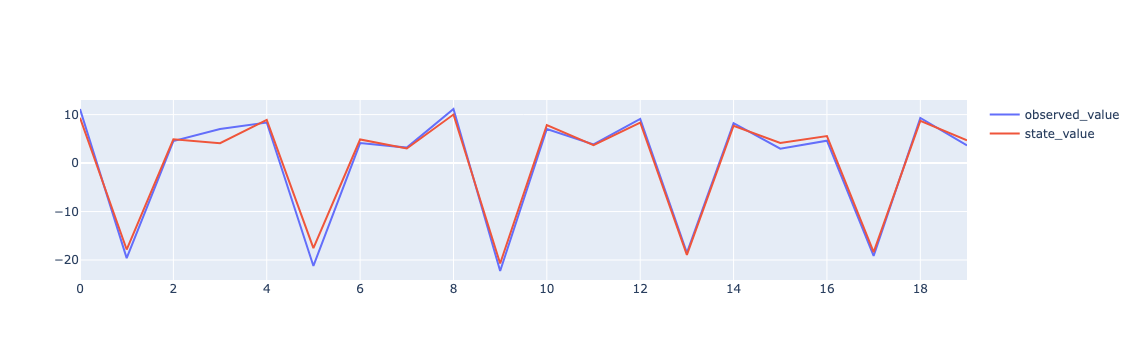

In [210]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x[:, 0].reshape(-1), name="state_value"),
    ]
)
fig.show()

### カルマンフィルタ

In [211]:
m = np.zeros((T, 3))
C = np.zeros((T, 3, 3))
m[0] = m0
C[0] = C0
for t in range(1, T):
    m[t], C[t] = kalman_filter(m[t-1], C[t-1], y[t], G, f, W, V)

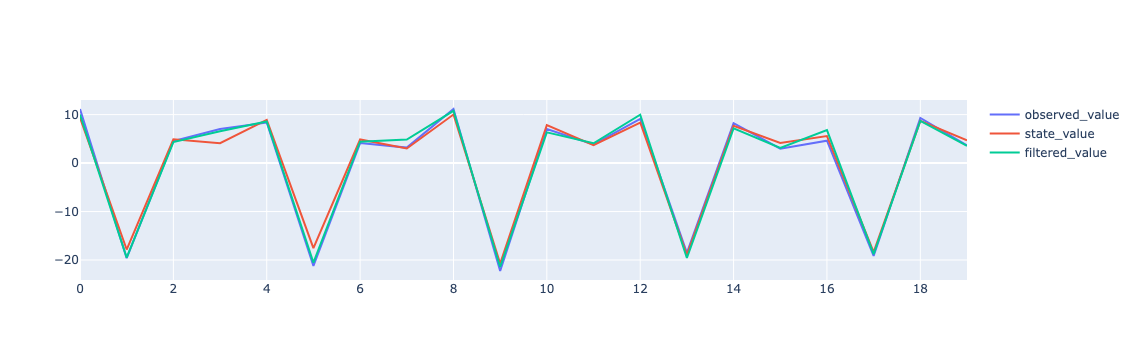

In [212]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x[:, 0].reshape(-1), name="state_value"),
        go.Scatter(x=np.arange(T), y=m[:, 0].reshape(-1), name="filtered_value"),
    ]
)
fig.show()

## ARMAモデル

### データ生成

In [217]:
# 設定
m0 = np.array([[10, 5, 3]]) # 状態変数の初期値（適当）
C0 = np.array([
    [9, 0, 0], 
    [0, 9, 0],
    [0, 0, 9]
]) # フィルタリング分布の共分散行列
G = np.array([
    [0.5, 1, 0], 
    [0.3, 0, 1],
    [0.2, 0, 0],
]) # 状態遷移行列
f = np.array([[1, 0, 0]]) # 観測行列
W = np.array([
    [1, 0, 0], 
    [0, 2, 0],
    [0, 0, 3]
]) # 状態雑音
V = np.array([[0]]) # 観測雑音
T = 20

In [218]:
x,y = linear_gauss_model(m=m0, G=G, f=f, W=W, V=V, T=T, dim=3)

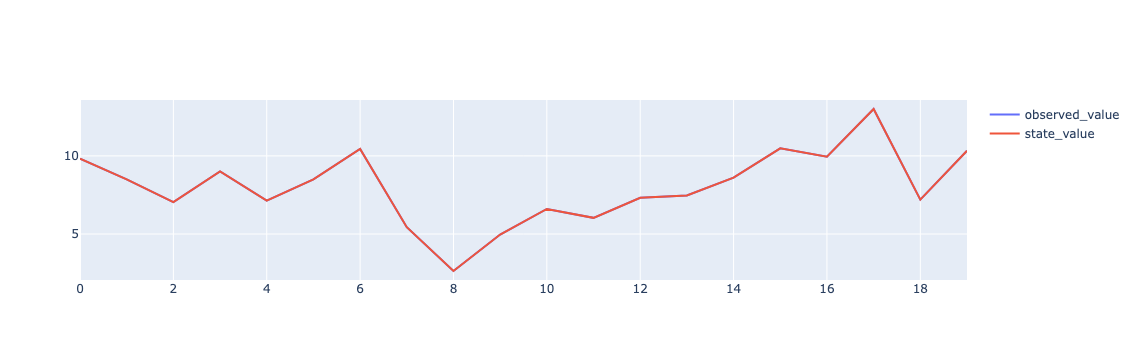

In [219]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x[:, 0].reshape(-1), name="state_value"),
    ]
)
fig.show()

### カルマンフィルタ

In [220]:
m = np.zeros((T, 3))
C = np.zeros((T, 3, 3))
m[0] = m0
C[0] = C0
for t in range(1, T):
    m[t], C[t] = kalman_filter(m[t-1], C[t-1], y[t], G, f, W, V)

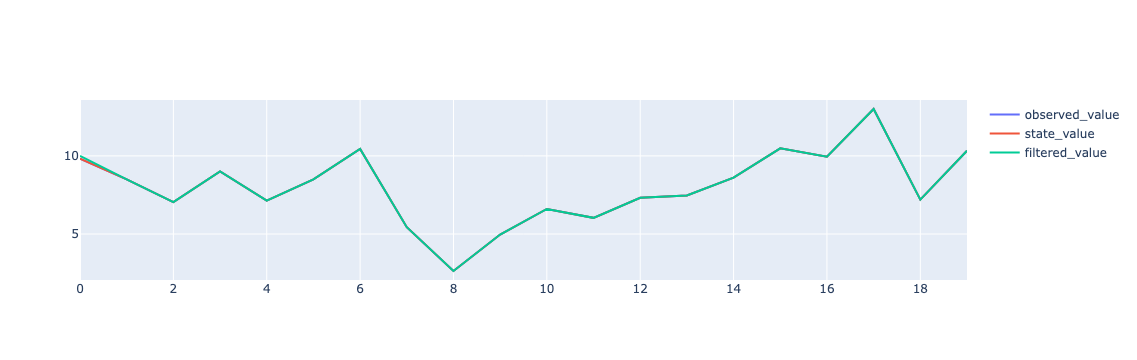

In [221]:
# 可視化
fig = go.Figure(
    data = [
        go.Scatter(x=np.arange(T), y=y.reshape(-1), name="observed_value"),
        go.Scatter(x=np.arange(T), y=x[:, 0].reshape(-1), name="state_value"),
        go.Scatter(x=np.arange(T), y=m[:, 0].reshape(-1), name="filtered_value"),
    ]
)
fig.show()